In [21]:
import pandas as pd
import os
import json

directory_path = "TL_out (2)"  

def extract_qa_by_item(json_data):
    rows = []
    id = json_data['info']['ID']
    crisis_stage = json_data['info']['위기단계']  # 위기단계 추가
    row = {'ID': id, '위기단계': crisis_stage}  # 위기단계 칼럼 추가
    qa_count = 1  
    
    for item in json_data['list']:
        for sub_item in item['list']:
            if 'audio' in sub_item:
                for audio_item in sub_item['audio']:
                    if audio_item['type'] == 'Q':
                        row[f'질문{qa_count}'] = audio_item['text']
                    elif audio_item['type'] == 'A':
                        row[f'응답{qa_count}'] = audio_item['text']
                        qa_count += 1  
                        
    rows.append(row)  
    return rows

all_rows = []

for filename in os.listdir(directory_path):
    if filename.endswith(".json"):  # .json 파일만 처리
        with open(os.path.join(directory_path, filename), 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            rows = extract_qa_by_item(json_data)  # 각 JSON 파일에서 문항별 질문과 응답 추출
            all_rows.extend(rows)  # 추출된 데이터를 전체 리스트에 추가

# 데이터프레임으로 변환
df = pd.DataFrame(all_rows)


# 데이터프레임을 CSV로 저장
df.to_csv("qa_by_item_separated_by_id.csv", index=False)


In [23]:
import pandas as pd

file_path = 'qa_by_item_separated_by_id.csv'

data = pd.read_csv(file_path)

# '위기단계' 값을 이진 값으로 변환할 새로운 열 생성
mapping = {'정상군': 0.0, '상담필요': 1.0, '관찰필요': 1.0, '학대의심': 1.0, '위기아동': 1.0, '해당없음': 1.0, '응급': 1.0}

# 이진 변환 열 추가 및 명시적으로 float로 변환
data['이진_위기단계'] = data['위기단계'].replace(mapping).astype(float)

# 결과 출력 (첫 5행)
simplified_data = data[['위기단계', '이진_위기단계']].head()
print(simplified_data)


   위기단계  이진_위기단계
0  학대의심      1.0
1  학대의심      1.0
2  상담필요      1.0
3    응급      1.0
4  학대의심      1.0


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2120\3527863004.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['이진_위기단계'] = data['위기단계'].replace(mapping).astype(float)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import pandas as pd

df = data.copy()

# 모든 질문 및 응답 데이터를 하나의 텍스트로 결합 (질문1~응답100)
df['모든_질문_응답'] = df.apply(lambda row: ' '.join([str(row[f'질문{i}']) + ' ' + str(row[f'응답{i}']) 
                                                      for i in range(1, 101) if pd.notna(row[f'질문{i}'])]), axis=1)

# 결측값을 처리 (타겟 변수 '이진_위기단계'가 None인 경우 제거)
df = df.dropna(subset=['이진_위기단계'])

# TF-IDF로 텍스트 데이터를 벡터화
tfidf = TfidfVectorizer(max_features=1000)  # max_features는 필요에 따라 조정 가능
X = tfidf.fit_transform(df['모든_질문_응답'])

# 타겟 변수 (정상군=0, 위기아동=1)
y = df['이진_위기단계']

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = xgb_clf.predict(X_test)

# 결과 평가
print(classification_report(y_test, y_pred))


C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:39:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.76      0.61      0.68       118
         1.0       0.90      0.95      0.93       458

    accuracy                           0.88       576
   macro avg       0.83      0.78      0.80       576
weighted avg       0.87      0.88      0.88       576



C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\

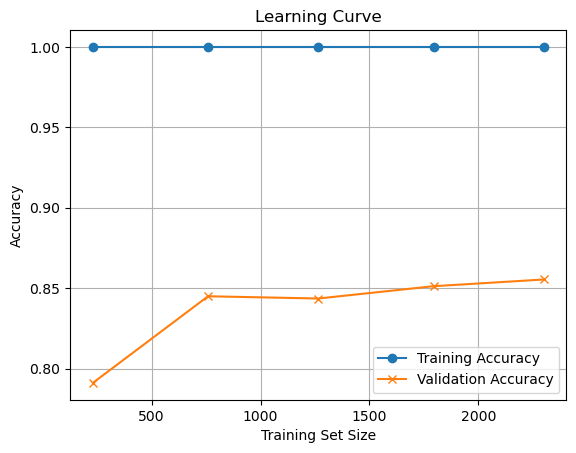

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선 생성 (X와 y는 이전에 TF-IDF로 변환한 데이터와 타겟)
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_clf, X, y, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], cv=5, scoring='accuracy')

# 학습 및 검증 정확도의 평균 계산
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# 학습 곡선 시각화
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy', marker='x')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# XGBoost 모델 설정 (복잡도를 줄이기 위한 하이퍼파라미터 조정)
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    max_depth=4,             # 트리 깊이를 줄임
    min_child_weight=3,      # 최소 리프 노드 가중치 증가
    subsample=0.8,           # 학습 데이터 샘플 비율 감소
    colsample_bytree=0.8,    # 사용할 특징의 비율 감소
    learning_rate=0.05,      # 학습률 감소
    n_estimators=100,        # 트리의 개수 조정
    eval_metric='logloss'
)

# 모델 학습
xgb_clf.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = xgb_clf.predict(X_test)

# 결과 평가
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.77      0.60      0.68       118
         1.0       0.90      0.95      0.93       458

    accuracy                           0.88       576
   macro avg       0.84      0.78      0.80       576
weighted avg       0.88      0.88      0.88       576



In [11]:
from imblearn.over_sampling import SMOTE

# SMOTE를 사용해 오버샘플링
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [13]:
# scale_pos_weight 설정 (1.0 클래스의 비율에 맞게 조정)
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', 
                        scale_pos_weight=len(y[y == 0]) / len(y[y == 1]))

xgb_clf.fit(X_train, y_train)


C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:12:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', 
                        scale_pos_weight=1, max_depth=5, learning_rate=0.05, n_estimators=100)

xgb_clf.fit(X_train, y_train)


C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:12:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [17]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# SMOTE를 사용하여 클래스 불균형 해결 (오버샘플링)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습 데이터와 테스트 데이터로 분리 (오버샘플링 후)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# XGBoost 모델 학습 (클래스 가중치 추가)
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', 
                        scale_pos_weight=len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1]),
                        max_depth=5, learning_rate=0.05, n_estimators=100)
xgb_clf.fit(X_train_resampled, y_train_resampled)

# 테스트 데이터로 예측 수행
y_pred_resampled = xgb_clf.predict(X_test_resampled)

# 결과 평가 출력
report = classification_report(y_test_resampled, y_pred_resampled)
print(report)


C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93       445
         1.0       0.92      0.94      0.93       467

    accuracy                           0.93       912
   macro avg       0.93      0.93      0.93       912
weighted avg       0.93      0.93      0.93       912



C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\wpsxk\anaconda3\Lib\site-packages\

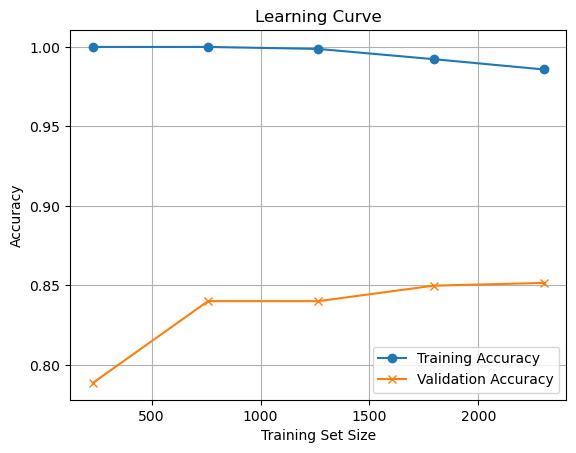

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve

# 학습 곡선 생성 (X와 y는 이전에 TF-IDF로 변환한 데이터와 타겟)
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_clf, X, y, train_sizes=[0.1, 0.33, 0.55, 0.78, 1.0], cv=5, scoring='accuracy')

# 학습 및 검증 정확도의 평균 계산
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)

# 학습 곡선 시각화
plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy', marker='x')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
